In [71]:
from typing import List
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from jaxtyping import Array
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from chainconsumer import Chain, ChainConsumer
import tensorflow_probability.substrates.jax.distributions as tfd

from imnn.utils import get_dataloaders, get_fiducials_derivatives_dataloaders
from imnn.train import loss_fn, get_F, update

In [72]:
class Linear(eqx.Module):
    weight: Array
    bias: Array

    def __init__(self, in_size, out_size, *, key):
        key_w, _ = jr.split(key)
        self.weight = jr.normal(key_w, (out_size, in_size)) 
        self.bias = jnp.zeros((out_size,))

    def __call__(self, x):
        return self.weight @ x + self.bias

class IMNN(eqx.Module):
    layers: List

    def __init__(self, in_size, out_size, width_size, depth, activation, *, key):
        layers = []
        dimensions = [in_size] + [width_size] * depth + [out_size]
        for _in, _out in zip(dimensions[:-1], dimensions[1:]):
            key, _key = jr.split(key)
            layers.append(eqx.nn.Linear(_in, _out, key=_key))
            layers.append(activation)
        self.layers = tuple(layers[:-1])

    def __call__(self, d):
        for l in self.layers:
            d = l(d)
        return d

In [73]:
key = jr.PRNGKey(0)

parameter_names = [r"$\sigma$"]
alpha = jnp.array([1.])
prior = tfd.Uniform(low=0., high=10.)

In [74]:
data_dim = 10
n_s = 8000
n_d = 800 # Derivatives

def simulator(sigma, key):
    return jr.normal(key, (data_dim,)) * sigma

# Generate simulations/derivatives at fiducial parameters
keys = jr.split(key, n_s)
alphas = jnp.tile(alpha, (len(keys), 1))

fiducials = jax.vmap(simulator)(alphas, keys)

derivatives = jax.vmap(jax.jacfwd(simulator, argnums=0))(alphas, keys)
derivatives = derivatives[:n_d].reshape(n_d, 1, data_dim)

In [75]:
# Calculate analytic Fisher information as well as estimate from measurements
C = jnp.cov(fiducials, rowvar=False)
H = (n_s - data_dim - 2) / n_s
Cinv = H * jnp.linalg.inv(C)

dmu = derivatives.mean(axis=0)

F_est = jnp.linalg.multi_dot([dmu, Cinv, dmu.T])
F_true = jnp.array([[0.5 * data_dim]]) / jnp.square(alpha)
Finv_true = jnp.linalg.inv(F_true)

# True analytic Fisher information for likelihood 
log_F_true = jnp.linalg.slogdet(F_true)
log_F_true = log_F_true[0] * log_F_true[1]

print("F_est, F_true", F_est, F_true)
print("log|F| true (sign, abs det.)", log_F_true)

F_est, F_true [[0.00873913]] [[5.]]
log|F| true (sign, abs det.) 1.609438


In [76]:
# Training loop for simple IMNN
split = 0.5 
batch_size = 1000
batch_size_dd = 800
lr = 3.e-4 
optimizer = optax.sgd(lr) # or adam
patience = 5
n_epochs = 5_000
min_train_epochs = 1000

n_s, data_dim = fiducials.shape
n_derivatives, *_ = derivatives.shape

key, model_key = jr.split(key)

f = IMNN(
    in_size=fiducials.shape[-1], 
    out_size=alpha.size, 
    width_size=5, 
    depth=2, 
    activation=jax.nn.relu, 
    key=model_key
)

# Need dataloader to return (d, d(data)/dalpha, alpha),
# during training alpha is always alpha^0
n_train = int(split * n_s) - n_derivatives 
n_valid = n_s - n_train

# Split derivatives (same as in dataloaders)
dd_train, dd_valid = jnp.split(
    derivatives, [int(split * n_derivatives)]
)
fiducials_train, fiducials_valid = jnp.split(
    fiducials[:n_derivatives], [int(split * n_derivatives)]
)

grad_fn = eqx.filter_value_and_grad(loss_fn, has_aux=True)

In [77]:
key, key_data, key_dd = jr.split(key, 3)

# Initialise model + optimiser
opt_state = optimizer.init(eqx.filter(f, eqx.is_inexact_array))

_d0_train, _d0_valid = jnp.split(
    fiducials[n_derivatives:], [int(split * (n_s - n_derivatives))]
)

# Dataloaders for paired fiducial data and their derivatives
fids_dd_dl_train, fids_dd_dl_valid = get_fiducials_derivatives_dataloaders(
    key_dd, (fiducials_train, dd_train), (fiducials_valid, dd_valid)
)

# Dataloaders of fiducials for epoch, not using first N belonging to derivatives
train_dl, valid_dl = get_dataloaders(key_data, _d0_train, _d0_valid)

# Fisher determinant + summary covariance metric
metrics = np.zeros((n_epochs, 2))

# Early stopping stuff
best_F = -jnp.inf 

# Patience counter
counter = 0

with trange(n_epochs) as epochs:
    for e in epochs:
        # Epoch metrics
        L_steps_train, L_steps_valid = [], [] 

        # Train
        for d0_train, fdd_train, n in zip(
            train_dl.loop(batch_size), 
            fids_dd_dl_train.loop(batch_size_dd), 
            range(train_dl.n_batches(batch_size))
        ):
            # d(-|F(x)| + |C(x)|)/d(phi)
            (L, (L_F, L_C, *_)), dLdp = grad_fn(
                f, d0=d0_train, fiducials_and_derivatives=fdd_train
            )
            f, opt_state = update(f, dLdp, opt_state, optimizer)

            L_steps_train.append((L_F, L_C))

        # Validate
        for d0_valid, fdd_valid, n in zip(
            valid_dl.loop(batch_size), 
            fids_dd_dl_valid.loop(batch_size_dd), 
            range(valid_dl.n_batches(batch_size))
        ):
            L_valid, (L_valid_F, L_valid_C, *_) = loss_fn(
                f, d0=d0_valid, fiducials_and_derivatives=fdd_valid
            )

            L_steps_valid.append((L_valid_F, L_valid_C))

        # Store metrics
        epoch_F, epoch_C = jnp.asarray(L_steps_train).mean(axis=0)
        epoch_valid_F, epoch_valid_C = jnp.asarray(L_steps_valid).mean(axis=0)

        metrics[e] = (epoch_F, epoch_valid_F)

        epochs.set_description(
            f"\re={e:04d}" +
            f" |F|={epoch_F:.3E}" + 
            f" |F_v|={epoch_valid_F:.3E}" + 
            f" |F_b|={best_F:.3E}" + 
            f" c={patience - counter}"
        )

        # Test patience: note minimising -|F| so compare |F| from validation
        if e > min_train_epochs:
            if epoch_valid_F > best_F:
                best_F = epoch_valid_F 
                counter = 0
            else:
                counter = counter + 1
                if counter >= patience:
                    epochs.set_description(
                        f"\nStopping training at epoch {e}, |F_t|={epoch_F:.3E}, |F_v|={epoch_valid_F:.3E}."
                    )
                    break

  0%|          | 0/5000 [00:00<?, ?it/s]

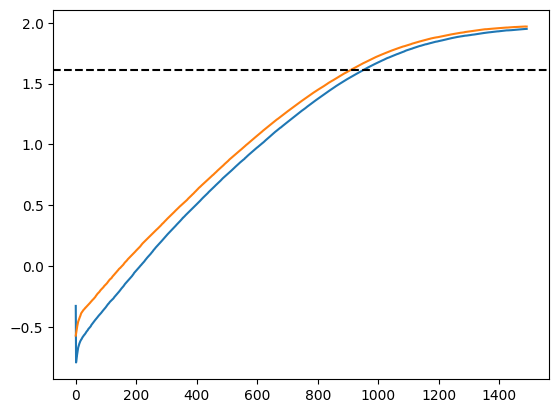

In [78]:
F_t, F_v = metrics[:e].T
plt.plot(F_t)
plt.plot(F_v)
plt.axhline(log_F_true, linestyle="--", color="k")
plt.show()

In [79]:
F, _ = get_F(fiducials, f, (fiducials[:len(derivatives)], derivatives))

a, b = jnp.linalg.slogdet(F)
log_F_f = a * b

(jnp.exp(log_F_true) / jnp.exp(log_F_f)).item()

0.7053595781326294

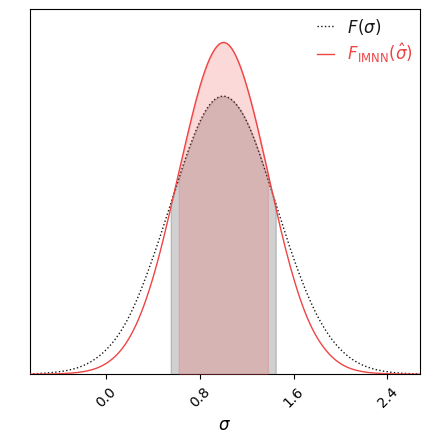

In [80]:
c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv_true,
        columns=parameter_names,
        name=r"$F(\sigma)$",
        color="k",
        linestyle=":"
    )
)
c.add_chain(
    Chain.from_covariance(
        alpha,
        jnp.linalg.inv(F),
        columns=parameter_names,
        name=r"$F_{\text{IMNN}}(\hat{\sigma})$",
        color="r",
    )
)
fig = c.plotter.plot()